## Looking at first data from DALEC since continuous deployment started

Just going to take a look at the data to see how it looks and test multilog loading

In [1]:
import pandas as pd
import dalecLoad
import numpy as np
import statistics
import matplotlib.pyplot as plt

In [ ]:
def load_DALEC_log(filepath, header=216, dropNA=True, longFormat=True, integerIndex=True, removeSaturated=True):
    """
    loads DALEC log file (excluding spectral wavelength mappings)
    optionally returns log file in long format
    option to convert sample no. index to an integer, or to keep as a string (integerIndex)
    """
    # ideally specify dtype of all rows for efficiency and to prevent bad things
    # need to specify str for lots of columns as these have some rows which contain stuff we need to remove
    DALEC_log = pd.read_csv(filepath,
                            header=header,
                            parse_dates=True,
                            dayfirst=True,
                            infer_datetime_format=True,
                            dtype={'Sample #': str,
                                   ' Lat': str, 
                                   ' Lon': str,
                                   ' Solar Azi': str,
                                   ' Solar Elev': str,
                                   ' Relaz': str,
                                   ' Heading': str,
                                   ' Pitch': str,
                                   ' Roll': str,
                                   ' Gearpos': str,
                                   ' Voltage': str,
                                   ' Temp': str,
                                   'Channel': str,
                                   ' Integration Time': str,
                                   ' Saturation Flag': str,
                                   ' Spec[21]': str,
                                   ' Spec[22]': str,
                                  },
                                   
                            )
    
    # any row with invalid UTC date can be removed
    DALEC_log.drop(DALEC_log[DALEC_log[' UTC Date'].isna()].index, inplace = True)
    # this removes the duplicated headings
    DALEC_log.drop(DALEC_log[DALEC_log[' UTC Date'] == 'UTC Date'].index, inplace = True)
    
    if dropNA:
        DALEC_log.dropna(inplace=True, axis=0,)
        
    if longFormat:
        # convert to long format
        # need to test that these variable names always load in this way (leading space on Spec etc.)
        DALEC_log = pd.wide_to_long(DALEC_log, [' Spec['], i=['Sample #', ' Channel'], j='spectral_ind', suffix='\d+]')
        DALEC_log.reset_index(level=2, inplace=True) # remove spectral_ind as an index
        DALEC_log['spectral_ind'] = pd.to_numeric(DALEC_log['spectral_ind'].str[:-1]) # convert spectral_ind to numeric
        DALEC_log.rename(columns={' Spec[': 'Spectral Magnitude'}, inplace=True)
        DALEC_log = DALEC_log.astype({'Spectral Magnitude': 'float64'})
        if integerIndex:
            # change sample no. index to integer
            print('WARNING: some of my old code wont work with integerIndex=True - delete this line once this is sorted')
            idx = DALEC_log.index
            DALEC_log.index = DALEC_log.index.set_levels([idx.levels[0].astype(int), idx.levels[1]])
        # sort index
        DALEC_log.sort_index(inplace=True)
        # change saturation flag to int.
        DALEC_log[' Saturation Flag'] = DALEC_log[' Saturation Flag'].astype(int)
        # format column as datetimes
        DALEC_log[' UTC Date'] = pd.to_datetime(DALEC_log[' UTC Date'], dayfirst=True, infer_datetime_format=True)
        # remove saturated readings - this hasn't been tested on a df which isn't in long format!
        if removeSaturated:
            indSat = DALEC_log[DALEC_log[' Saturation Flag'] == 1].index.get_level_values(0)
            if list(indSat): # checks if the list is empty
                DALEC_log.drop(indSat, level=0, axis=0, inplace=True)

    return DALEC_log


In [2]:
log71 = dalecLoad.load_DALEC_log('data/Jul-Aug/DALEC_71.dtf', integerIndex=True)

In [4]:
spect_wavelengths = dalecLoad.load_DALEC_spect_wavelengths('data/Jul-Aug/DALEC_71.dtf')

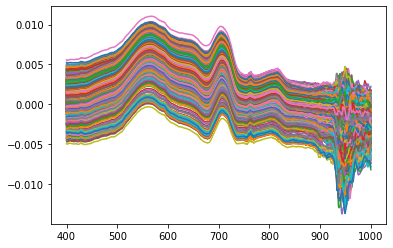

In [5]:
fig, ax = plt.subplots()
for sample in log71.index.get_level_values('Sample #').unique():
        spectra = dalecLoad.uniform_grid_spectra_Rrs(log71.loc[sample],
                                       spect_wavelengths)
        ax.plot(spectra['Wavelength'], (spectra['Rrs']))

In [15]:
# this needs more work!!!!

def multiLogLoad(filepath, 
                 sep=['DALEC (SN:0005)'],
                 header=216, 
                 dropNA=True,longFormat=True, 
                 integerIndex=True,
                 removeSaturated=True):
    """
    - loads multiple logs which are all contained in a single logfile (eg. that was generated using serial logging of DALEC
    - depending on how the logfile was generated, adjusting 'sep' might allow for different situations...
    - should probably think a bit more about this for a continuous logging application
    """
    # ideally specify dtype of all rows for efficiency and to prevent bad things - TODO!
    # need to specify str for lots of columns as these have some rows which contain stuff we need to remove
    col_names = pd.read_csv(filepath, nrows=0, header=header,).columns
    types_dict = {} # if I want to be more specific then I can specify any cols which I don't want to be str
    types_dict.update({col: str for col in col_names if col not in types_dict})
    types_dict.pop(' UTC Date', ' UTC Time') # want these to be formatted as datetime by pd.read_csv
    
    df = pd.read_csv(filepath,
                     header=header,
                     parse_dates=True,
                     dayfirst=True,
                     infer_datetime_format=True,
                     dtype=types_dict,
                     )
    
    groups = df['Sample #'].isin(sep).cumsum()
    names = ['Log ' + str(i) for i in range(len(set(groups)))] 
    tables = {name: g[1].iloc[1:] for g,name in zip(df.groupby(groups), names)} 
    # because we've used 'DALEC (SN:0005)' as the way to seperate logfiles, we need to remove the first lines before this
    # if a different sep is used, then this line may no longer work... so perhaps need to make this more robust!
    tables.pop('Log 0')
    print(len(tables))
    for name, table in tables.items():
        # any row with invalid UTC date can be removed
        table.drop(table[table[' UTC Date'].isna()].index, inplace = True)
        # this removes the duplicated headings
        table.drop(table[table[' UTC Date'] == 'UTC Date'].index, inplace = True)
        if dropNA:
            table.dropna(inplace=True, axis=0,)
        if longFormat:
            # convert to long format
            # need to test that these variable names always load in this way (leading space on Spec etc.)
            table = pd.wide_to_long(table, [' Spec['], i=['Sample #', ' Channel'], j='spectral_ind', suffix='\d+]')
            table.reset_index(level=2, inplace=True) # remove spectral_ind as an index
            table['spectral_ind'] = pd.to_numeric(table['spectral_ind'].str[:-1]) # convert spectral_ind to numeric
            table.rename(columns={' Spec[': 'Spectral Magnitude'}, inplace=True)
            table = table.astype({'Spectral Magnitude': 'float64'})
        if integerIndex:
            # change sample no. index to integer
            print('WARNING: some of my old code wont work with integerIndex=True - delete this line once this is sorted')
            idx = table.index
            table.index = table.index.set_levels([idx.levels[0].astype(int), idx.levels[1]])
        # sort index
        table.sort_index(inplace=True)
        # change saturation flag to int.
        table[' Saturation Flag'] = table[' Saturation Flag'].astype(int)
        # format column as datetimes
        table[' UTC Date'] = pd.to_datetime(table[' UTC Date'], dayfirst=True, infer_datetime_format=True)
        # remove saturated readings - this hasn't been tested on a df which isn't in long format!
        if removeSaturated:
            indSat = table[table[' Saturation Flag'] == 1].index.get_level_values(0)
            if list(indSat): # checks if the list is empty
                table.drop(indSat, level=0, axis=0, inplace=True)
        
        tables[name] = table
    return tables

In [18]:
tables = multiLogLoad('data/Jul-Aug/DALEC_72_73.dtf', sep=['Sample #'])

2


In [27]:
tables['Log 2']

spectral_ind  Pitch   Relaz  Roll    Temp  GPS_Fix  \
Sample #  Channel                                                       
7248     Ed                  21    0.0  -138.2  -1.0    37.5        F   
         Ed                  22    0.0  -138.2  -1.0    37.5        F   
         Ed                  23    0.0  -138.2  -1.0    37.5        F   
         Ed                  24    0.0  -138.2  -1.0    37.5        F   
         Ed                  25    0.0  -138.2  -1.0    37.5        F   
...                         ...    ...     ...   ...     ...      ...   
10939    Lu                 216    0.0  -135.9  -2.0  29.375        F   
         Lu                 217    0.0  -135.9  -2.0  29.375        F   
         Lu                 218    0.0  -135.9  -2.0  29.375        F   
         Lu                 219    0.0  -135.9  -2.0  29.375        F   
         Lu                 220    0.0  -135.9  -2.0  29.375        F   

                    Saturation Flag  Gearpos      UTC Time         Lat  \
Sample #  Channel                                                        
7248     Ed                       0    -62.2  10:00:04.150  56.1468505   
         Ed                       0    -62.2  10:00:04.150  56.1468505   
         Ed                       0    -62.2  10:00:04.150  56.1468505   
         Ed                       0    -62.2  10:00:04.150  56.1468505   
         Ed                       0    -62.2  10:00:04.150  56.1468505   
...                             ...      ...           ...         ...   
10939    Lu                       0    -57.3  11:59:58.886  56.1468505   
         Lu                       0    -57.3  11:59:58.886  56.1468505   
         Lu                       0    -57.3  11:59:58.886  56.1468505   
         Lu                       0    -57.3  11:59:58.886  56.1468505   
         Lu                       0    -57.3  11:59:58.886  56.1468505   

                   Solar Azi  Voltage  Solar Elev  Heading   UTC Date  \
Sample #  Channel                                                       
7248     Ed            130.1     11.6        43.9     33.2 2022-07-30   
         Ed            130.1     11.6        43.9     33.2 2022-07-30   
         Ed            130.1     11.6        43.9     33.2 2022-07-30   
         Ed            130.1     11.6        43.9     33.2 2022-07-30   
         Ed            130.1     11.6        43.9     33.2 2022-07-30   
...                      ...      ...         ...      ...        ...   
10939    Lu            171.4     11.6        52.1     35.5 2022-07-30   
         Lu            171.4     11.6        52.1     35.5 2022-07-30   
         Lu            171.4     11.6        52.1     35.5 2022-07-30   
         Lu            171.4     11.6        52.1     35.5 2022-07-30   
         Lu            171.4     11.6        52.1     35.5 2022-07-30   

                           Lon  Integration Time  Spectral Magnitude  
Sample #  Channel                                                     
7248     Ed        -3.92305679                57            0.107953  
         Ed        -3.92305679                57            0.108974  
         Ed        -3.92305679                57            0.106759  
         Ed        -3.92305679                57            0.101189  
         Ed        -3.92305679                57            0.100306  
...                        ...               ...                 ...  
10939    Lu        -3.92305679                96            0.001343  
         Lu        -3.92305679                96            0.000877  
         Lu        -3.92305679                96            0.000989  
         Lu        -3.92305679                96            0.000968  
         Lu        -3.92305679                96            0.000838  

[2212800 rows x 18 columns]

KeyError: 'Lsky'

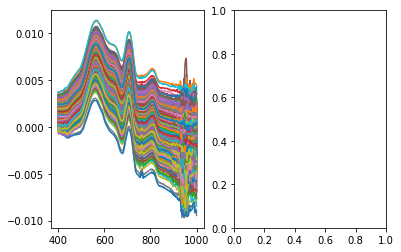

In [28]:
fig, ax = plt.subplots(1, 2)
for i in range(len(tables)-1):
    ind = list(tables.keys())[i]
    for sample in tables[ind].index.get_level_values('Sample #').unique():
        spectra = dalecLoad.uniform_grid_spectra_Rrs(tables[ind].loc[sample],
                                           spect_wavelengths)
        ax[i].plot(spectra['Wavelength'], (spectra['Rrs']))